# Exercise 3 : Stochastic Gradient Learning in Neural Networks

**Théau Blanchard**

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


np.random.seed(1312)

## Question 1

On cherche à minimiser sur $w \in \mathbb{R}$
$$
R_n (w) = \frac{1}{n} \displaystyle\sum_{i=1}^n (y_i - w^Tx_i)^2
$$
Ce qui est l'écriture empirique du problème suivant :
$$
\text{min}_w \mathbb{E}[j( (X,Y) , w)]
$$
où $j[(X,Y),w] = (Y-w^TX)^2$ est fortement convexe.

Ainsi $j$ est continue et différentiable en $w$ partout de sorte que :

$\nabla_wj[(X,Y),w] = -2X(Y-w^TX)$

On constate alors que le gradient n'est pas borné et que donc on n'aura pas forcément la convergence de l'algorithme du gradient stochastique. Pour l'avoir on va alors projeter $w$ sur la boule unité qui est convexe et bornée.

On considère la suite des $\epsilon_k = \frac{1}{k+1}$ qui vérifie les hypothèses de convergence du gradient stochastique.

Supposons que l'on ait $N$ échantillons $(x_i,y_i)$. L'algorithme du gradient stochastique avec un critère d'arret sur le nombre d'itération s'écrit alors :

- Pour $k$ allant de $0$ à $k_{max}$ :
    - Échantilloner $i \sim{} \mathcal{U}([0,N-1])$
    - $\epsilon_k = \frac{1}{k+1}$
    - $w_{k+1} = w_k - \epsilon_k \nabla_w j[(x_i,y_i),w_k]$


In [83]:
def grad_sto(w_0,dj,X,Y,k_max=50):
    '''
    w_0 : initial parameter to optmize
    dj : gradient of the cost function
    X, Y : data to sample from
    k_max : stopping criterion
    '''
    w_k = w_0
    estimation = []
    for k in range(k_max):
        # Sample the parameter
        idx = np.random.randint(0,len(Y))
        y_k, x_k = Y[idx], X[idx]
        # Step size
        e_k = 1/(k+1)
        # Parameter update
        w_k = w_k -e_k * dj(w_k,y_k,x_k)
        # Projection inside the unit circle
        w_k = w_k / np.linalg.norm(w_k) if np.linalg.norm(w_k)>1  else w_k
        estimation.append(w_k)
    return w_k,estimation

In [84]:
def R_n(y,X,w):
    return np.mean(np.square(y - (X@w)))

def j(y,w,x):
    x = x.reshape(-1,1)
    return np.square(y - w.T@x)

def dj(w,y,x):
    x = x.reshape(-1,1)
    return -2* x @(y - w.T@x)

## Question 2

On échantillonne les données dans $[-1,1]^2$.

In [85]:
N_pts = 500

X = 2*np.random.random((N_pts,2))-1
w_bar = 2*np.random.random((2,1))-1
w_bar = w_bar / np.linalg.norm(w_bar) if np.linalg.norm(w_bar)>1  else w_bar
y = np.where((X @ w_bar)>=0,1,-1)


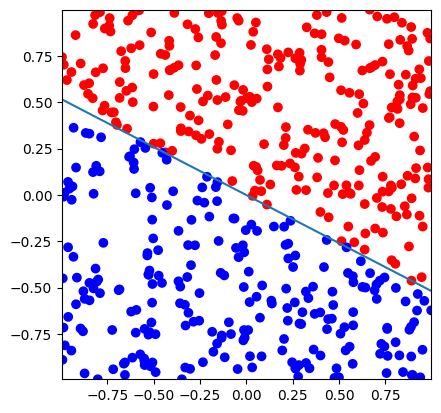

In [86]:
def plot_data(X,y,w,title = None):
    fig = plt.figure()
    ax = fig.add_subplot()

    col = np.where(y.flatten()==1,'b','r')
    plt.scatter(X[:,0],X[:,1],c=col)
    #plt.scatter(w[0,0],w[1,0])

    w_norm = np.array([-w[1],w[0]])
    a= w_norm[1]/w_norm[0]

    #plt.scatter(w_norm[0],w_norm[1])

    plt.plot([-1,1],[a*np.min(X[:,0]),a*np.max(X[:,1])])
    #plt.quiver(0,0,w[0],w[1],angles='xy')

    plt.xlim(np.min(X[:,0]),np.max(X[:,0]))
    plt.ylim(np.min(X[:,1]),np.max(X[:,1]))

    ax.set_aspect('equal', adjustable='box')
    if title is not None : 
        ax.set_title(title)
plot_data(X,y,w_bar)

## Question 3

On constate finalement que l'on a finalement bien atteint une convergence telle qu'avec le paramètre estimé, le risque est minimum sur les données. De manière intéressante, on obtient un risque inférieur au risque que l'on a avec le paramètre qui a servi à générer les données. Le paramètre estimé est aussi différent du paramètre initial. Le raison derrière celà est liée à la métrique que l'on a cherché à optimiser. Le paramètre $\bar{w}$ est le paramètre qui minimise la précision mais n'a a priori rien à voir avec le risque quadratique que $w^*$ minimise.

In [87]:
def accuracy(y_est,y):
    return np.mean(y==y_est)

Accuracy : 94.39999999999999 %
Estimated hyperplan : [-0.24963399 -0.96802728]
True hyperplan      : [-0.24293396 -0.46746861]
Initial risk : 1.9637918513956938
Final risk   : 0.3399604667666833
True risk    : 0.5724752876657453


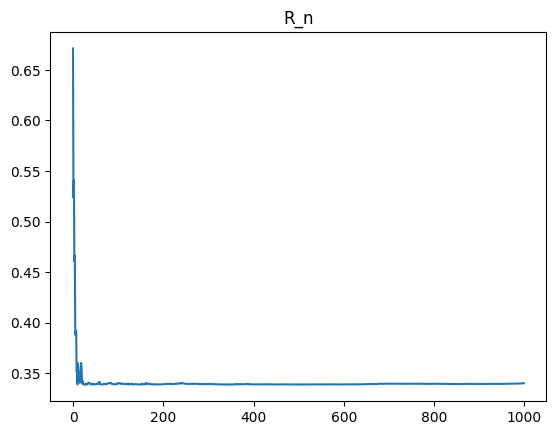

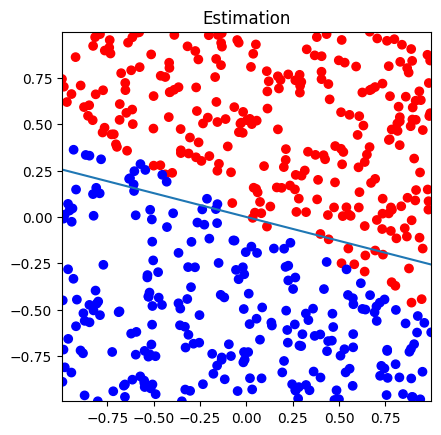

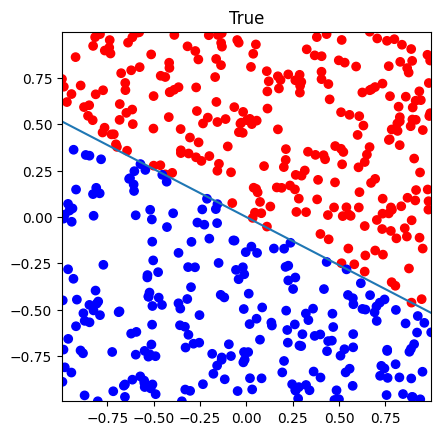

In [88]:
k_max = N_pts *2
w_0 = 2*np.random.random((2,1))-1
w_0 = w_0/np.linalg.norm(w_0) if np.linalg.norm(w_0) > 1 else w_0
w_est,estimation = grad_sto(w_0,dj,X,y,k_max=k_max)
y_est = np.where(X@w_est<0,-1,1)

loss = [R_n(y,X,est) for est in estimation]

print("Accuracy :",accuracy(y_est,y)*100,"%")
print("Estimated hyperplan :",w_est.flatten())
print("True hyperplan      :",w_bar.flatten())

print("Initial risk :", R_n(y,X,w_0))
print("Final risk   :", R_n(y,X,w_est))
print("True risk    :",R_n(y,X,w_bar))
plt.plot(loss)
plt.title("R_n")

plot_data(X,y,w_est,"Estimation")
plot_data(X,y,w_bar,"True")

## Question 4

Comme on l'a vu à la question précédente, il n'est pas forcément pertinent de comparer $\bar{w}$ avec $w^*_{\text{noisy}}$. En revanche on peut tester la robustesse de la descente de gradient stochastique au bruit en comparant $w^*$ et  $w^*_{\text{noisy}}$. On constate empiriquement que tant que le niveau de bruit reste assez faible, on obtient un résultat assez fidèle au vrai résultat.

The noisy data leads to the missclassification of 65 points
ie an accuracy of 87.0 %


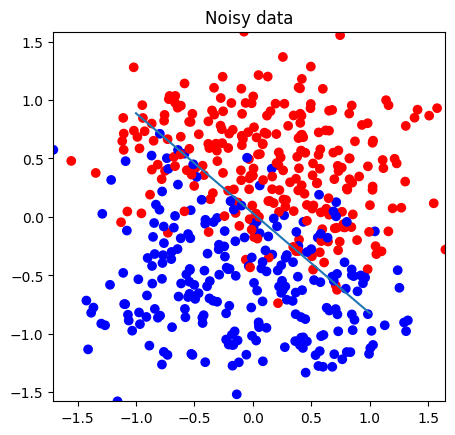

In [89]:
sigma = 0.3
X_noisy = X + np.random.normal(0,sigma,size = X.shape)
y_noisy =  np.where(X_noisy@w_bar<0,-1,1)

print("The noisy data leads to the missclassification of",np.sum(y_noisy != y),"points")
print("ie an accuracy of",accuracy(y_noisy,y)*100,"%")

plot_data(X_noisy,y,w_bar,"Noisy data")
plt.show()

Accuracy : 86.4 %
Estimated hyperplan with noise    : [-0.29000594 -0.95697152]
Estimated hyperplan without noise : [-0.24963399 -0.96802728]
True hyperplan                    : [-0.24293396 -0.46746861]

Écart relatif entre les deux estimation 0.041867647423357544

Initial risk              : 2.044860438355868
Final risk                : 0.4356872590989289
True risk with noisy data : 0.60357143462861


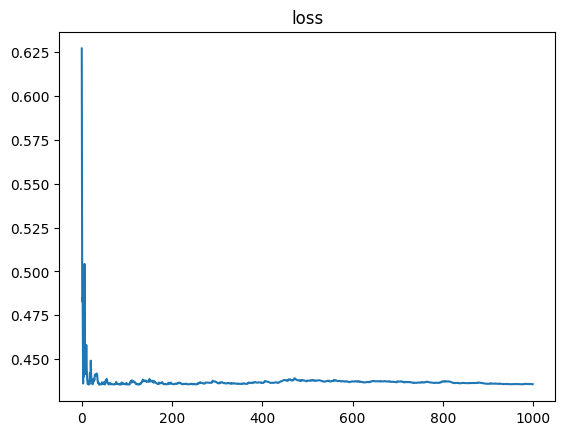

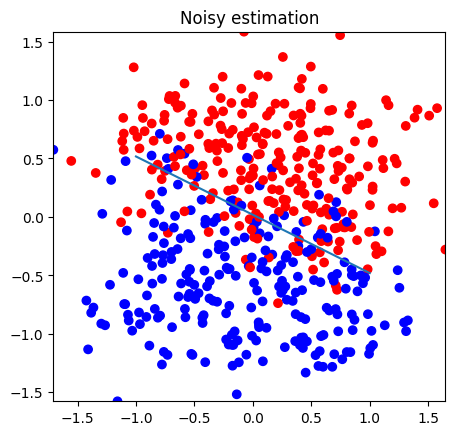

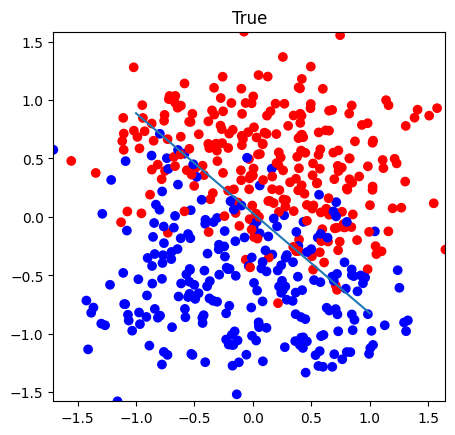

In [90]:
w_est_noisy,estimation = grad_sto(w_0,dj,X_noisy,y,k_max=k_max)

y_est_noisy = np.where(X_noisy@w_est<0,-1,1)

loss = [R_n(y,X_noisy,est) for est in estimation]

print("Accuracy :",accuracy(y_est_noisy,y)*100,"%")
print("Estimated hyperplan with noise    :",w_est_noisy.flatten())
print("Estimated hyperplan without noise :",w_est.flatten())
print("True hyperplan                    :",w_bar.flatten())

print("\nÉcart relatif entre les deux estimation",np.linalg.norm(w_est-w_est_noisy/np.linalg.norm(w_est)))

print("\nInitial risk              :", R_n(y,X_noisy,w_0))
print("Final risk                :", R_n(y,X_noisy,w_est_noisy))
print("True risk with noisy data :", R_n(y,X_noisy,w_bar))
plt.plot(loss)
plt.title("loss")
plot_data(X_noisy,y,w_est_noisy,"Noisy estimation")
plot_data(X_noisy,y,w_bar,"True")

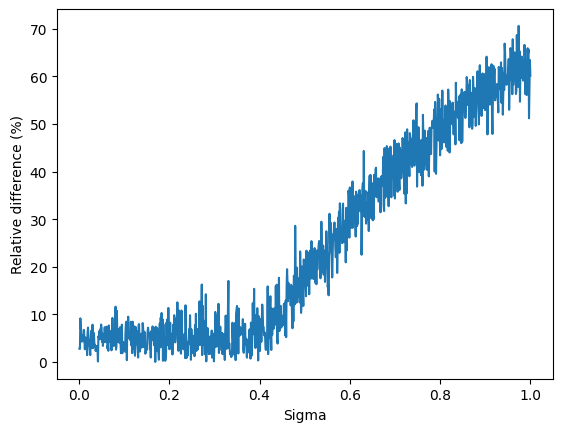

In [91]:
def sensitivity(X,y,w_0,sigma,w_est):
    X_sigma = X + np.random.normal(0,sigma,size = X.shape)
    w_est_sigma,_ = grad_sto(w_0,dj,X_sigma,y,k_max=k_max)

    y_est_sigma = np.where(X_noisy@w_est<0,-1,1)

    loss =R_n(y,X_sigma,w_est_sigma)

    rel_diff = np.linalg.norm(w_est - w_est_sigma)/ np.linalg.norm(w_est)

    return rel_diff,loss

sigma_list = [0.001*k for k in range(1,1001)]
rel_diff_list = []
for sig in sigma_list:
    rel, _ = sensitivity(X,y,w_0,sig,w_est)
    rel_diff_list.append(rel*100)

plt.plot(sigma_list,rel_diff_list)
plt.xlabel("Sigma")
plt.ylabel("Relative difference (%)")
plt.show()
    

## Question 5

On remet les valeurs des classes de {2,4} à {-1,1} et on normalise les données.

Finalement on voit qu'une classification par estimation d'un hyperplan qui sépare les données en minimisant le risque quadratique est une technique efficace pour ce jeu de données car on obtient une précision d'environ 97%.

In [92]:
df = pd.read_csv('./data/breast-cancer-wisconsin.data',header=None)
df = df.replace("?",np.NaN).dropna() # On retire les entrées avec des valeurs manquantes

In [93]:
y = df[10].to_numpy()
y = y.reshape(-1,1)
y -= 3 
X = df.drop(columns=[0,10]) # On enlève l'id et la classe
X = X.to_numpy(dtype = int)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1312)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [95]:
k_max = len(X) * 5
w_0 = 2*np.random.random((9,1))-1
w_0 = w_0/np.linalg.norm(w_0) if np.linalg.norm(w_0) > 1 else w_0

w_est,estimation = grad_sto(w_0,dj,X_train,y_train,k_max=k_max)
y_est_train = np.where(X_train@w_est<0,-1,1)
y_est_test = np.where(X_test@w_est<0,-1,1)

print("Accuracy train :",accuracy(y_est_train,y_train)*100,"%")
print("Accuracy test :",accuracy(y_est_test,y_test)*100,"%")
print("Estimated hyperplan :",w_est.flatten())

Accuracy train : 97.25274725274726 %
Accuracy test : 99.27007299270073 %
Estimated hyperplan : [ 0.20481004  0.20739964 -0.00344893  0.06073714  0.0185402   0.33672037
  0.0727694   0.13923608  0.01438432]
